### **Cluster Analysis:** Based on the bike rental demand patterns, can you identify clusters of trip types?


## Imports

In [2]:
# Data Processing 
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# needed for clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# distance calculation
import geopy.distance


## Load preprocessed data

In [3]:
# our preprocessed DataFrame is loaded
cluster_data = pd.read_pickle('PreprocessedDataframe.pk')

In [4]:
cluster_data.head(2)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,tripduration,start_station_name,end_station_name,start_latitude,...,end_latitude,end_longitude,start_date_time,start_max_temp,start_min_temp,start_precip,end_date_time,end_max_temp,end_min_temp,end_precip
0,2016-01-01 00:17:15,2016-01-01 00:22:39,110,88,620,Subscriber,0 days 00:05:24,Harvard University Gund Hall at Quincy St / Ki...,Inman Square at Vellucci Plaza / Hampshire St,42.376369,...,42.374035,-71.101427,2016-01-01,5.6,5.6,0,2016-01-01 00:00:00,5.6,5.6,0
1,2016-01-01 00:15:36,2016-01-01 00:31:17,36,67,913,Customer,0 days 00:15:41,Boston Public Library - 700 Boylston St.,MIT at Mass Ave / Amherst St,42.349673,...,42.358100,-71.093198,2016-01-01,5.6,5.6,0,2016-01-01 01:00:00,5.0,5.0,0


## Clustering of Customer Types by duration and distance[1]


By clustering of tripduration and distance, we can potentially identify different trip types and or customer types. 

In [5]:
# Transforming booking duration to int
cluster_data['tripduration'] = cluster_data['tripduration'].apply(lambda x: x.total_seconds() / 60)

Create new distance column

In [6]:
# route combinations in our data
route_combinations = cluster_data[['start_station_id', 'end_station_id', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']].drop_duplicates().reset_index(drop = True)

# calculate distance
for i in route_combinations.index:
    start_latitude = route_combinations.loc[i, 'start_latitude']
    start_longitude = route_combinations.loc[i, 'start_longitude']
    end_latitude = route_combinations.loc[i, 'end_latitude']
    end_logitude = route_combinations.loc[i, 'end_longitude']
    try:
        route_combinations.loc[i, 'distance'] = geopy.distance.distance((start_latitude, start_longitude),
                                                                (end_latitude, end_logitude)).km
    except ValueError:
        route_combinations.loc[i, 'distance'] = -1

# merge with original data
cluster_data = pd.merge(cluster_data, route_combinations[['start_station_id', 'end_station_id', 'distance']], how='left', on = ['start_station_id', 'end_station_id'])

# drop two unfeasible data points: 
cluster_data = cluster_data[cluster_data['distance'] < 100]

In [7]:
# Features X for clustering as duration and distance 
X = cluster_data[['tripduration', 'distance']].copy()
X.dropna(axis=0, inplace=True)

In [8]:
# Data scaling because k-means is sensitive to outliers
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

<AxesSubplot:xlabel='tripduration', ylabel='distance'>

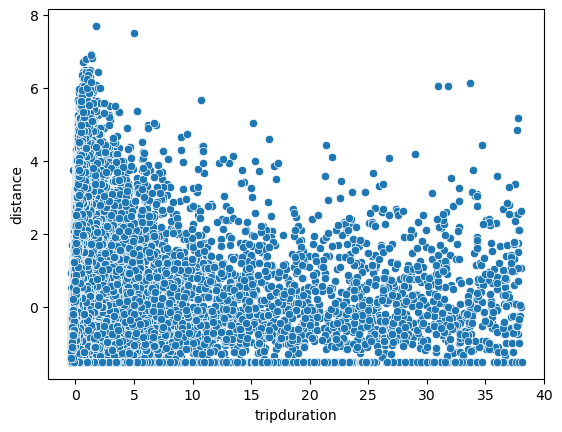

In [9]:
sns.scatterplot(x='tripduration',y='distance',data=X_scaled_df)

In [10]:
# Function as known from tutorial
def plot_elbow_graph(df):
    """
    The elbow method is used to visualize the cluster losses of k-means obtained by the model.inertia_ 
    """
    clusters = []
    losses = []
    for k in range(15):
        model = KMeans(n_clusters=k + 1, random_state=42, init='k-means++')
        model.fit(df)
        clusters.append(k + 1)
        losses.append(model.inertia_)

    plt.plot(clusters, losses)
    plt.show()

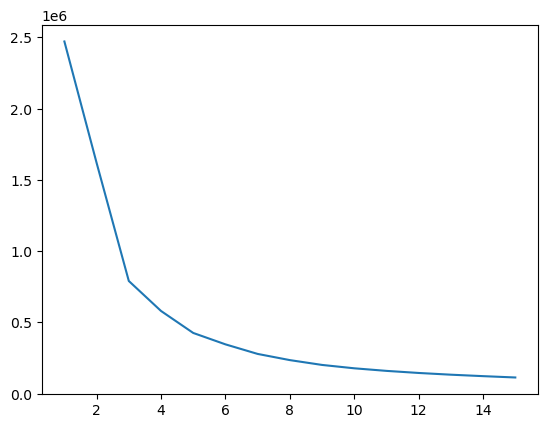

In [11]:
# Plotting elbow methodimport warnings
import warnings
warnings.filterwarnings('ignore')
plot_elbow_graph(X_scaled_df)

In [12]:
# Fit a k-means model with the scaled data
# K-Means is used because it is less sensitive to outliers
customer_type = KMeans(n_clusters = 5, random_state=42, init='k-means++')
customer_type.fit(X_scaled)
customer_type.predict(X_scaled)

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [13]:
# Inverse transform Data for interpretability
inverse_data = scaler.inverse_transform(X_scaled)
inverse_data_df = pd.DataFrame(inverse_data,columns=X.columns, index = X.index)
inverse_data_df.describe()

,tripduration,distance
count,1.235122e+06,1.235122e+06
mean,1.591946e+01,1.864539e+00
std,3.729771e+01,1.233020e+00
min,1.016667e+00,2.220446e-16
25%,6.616667e+00,9.524739e-01
50%,1.090000e+01,1.570986e+00
75%,1.785000e+01,2.489073e+00
max,1.436700e+03,1.134843e+01


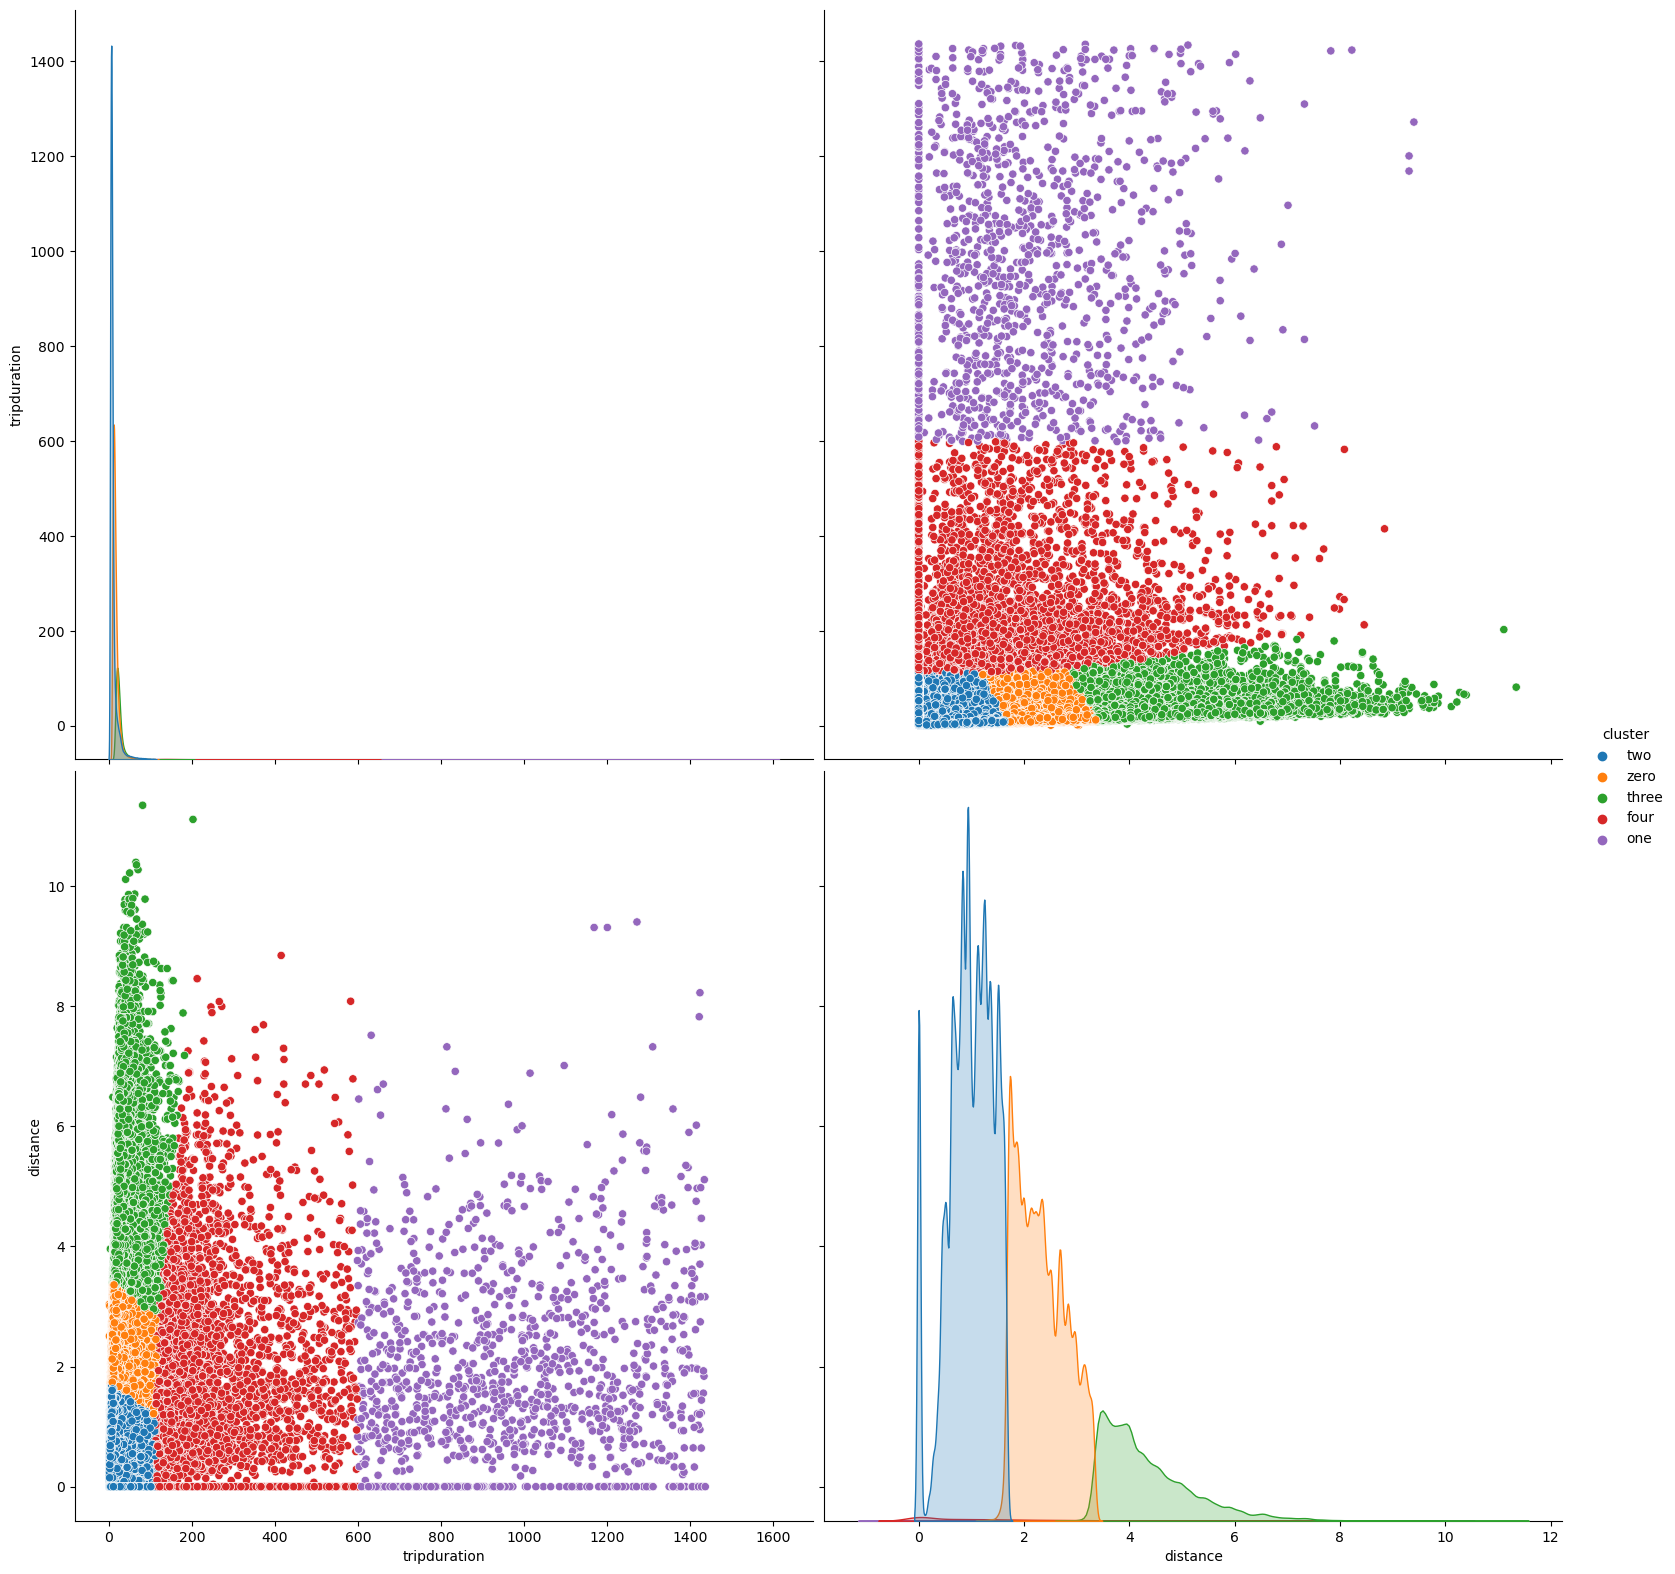

In [14]:
# Plotting the found cluster

numbers = ["zero", "one", "two", "three", "four"]

inverse_data_df["cluster"] = customer_type.predict(X_scaled)
inverse_data_df["cluster"] = inverse_data_df["cluster"].apply(lambda x: numbers[x])
sns.pairplot(data=inverse_data_df,height=8,hue='cluster',palette=sns.color_palette('tab10', 5))

[Text(0, 0.5, 'tripduration in s'),
 Text(0.5, 0, 'distance in km'),
 Text(0.5, 1.0, 'Trip types by duration and distance')]

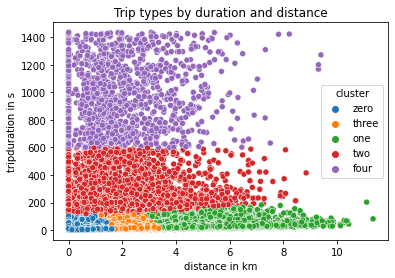

In [ ]:
sns.scatterplot(data=inverse_data_df, x='distance', y='tripduration', hue='cluster', palette=sns.color_palette('tab10', 5)).set(title='Trip types by duration and distance', ylabel='tripduration in s', xlabel='distance in km')

**Observations:** The Trips were divided in 5 clusters:
- zero: short tripduration and short distance of travel
- one: short tripduration but long distance of travel -> very fast customers
- two: medium tripduration and short to long distance of travel -> normal customers
- three: short tripduration and medium distance of travel -> fast customers
- four: long tripduration and short to long distance of travel -> slow customers

**Additional:** The line of dots along the x-axis in the lower left plot (of the pairplot) are bookings where the start and the end rental zone are the same. (Because the distance is zero when Start and Endstation are the same) These could be seen as round trips and can be devided into three gropus as well:
- very short: probably unintended, defect in bikes, etc.
- medium: regular roundtrips 
- long: probably long bike tours for leisure activities

## Clustering of Distance and Max Start Temperatur [2]

By clustering weather and distance information we can better understand the effect of weather on customer behaviour.

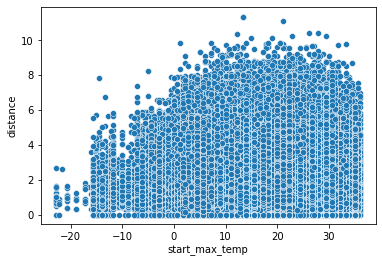

In [ ]:
# select culoms start_max_temp and distance 
weather_trip = cluster_data[['start_max_temp', 'distance']]
sns.scatterplot(x='start_max_temp',y='distance',data=weather_trip)

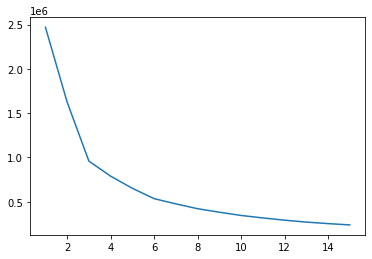

In [ ]:
# scale Data because K-Means is sensitive to outliers
scaler = StandardScaler()
weather_trip_scaled = weather_trip.copy()
weather_trip_scaled = scaler.fit_transform(weather_trip_scaled)

# plot elbow graph with scaled data
plot_elbow_graph(weather_trip_scaled)

In [ ]:
n_clusters = 5
model = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
model.fit(weather_trip_scaled)
weather_trip['cluster'] = model.predict(weather_trip_scaled)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


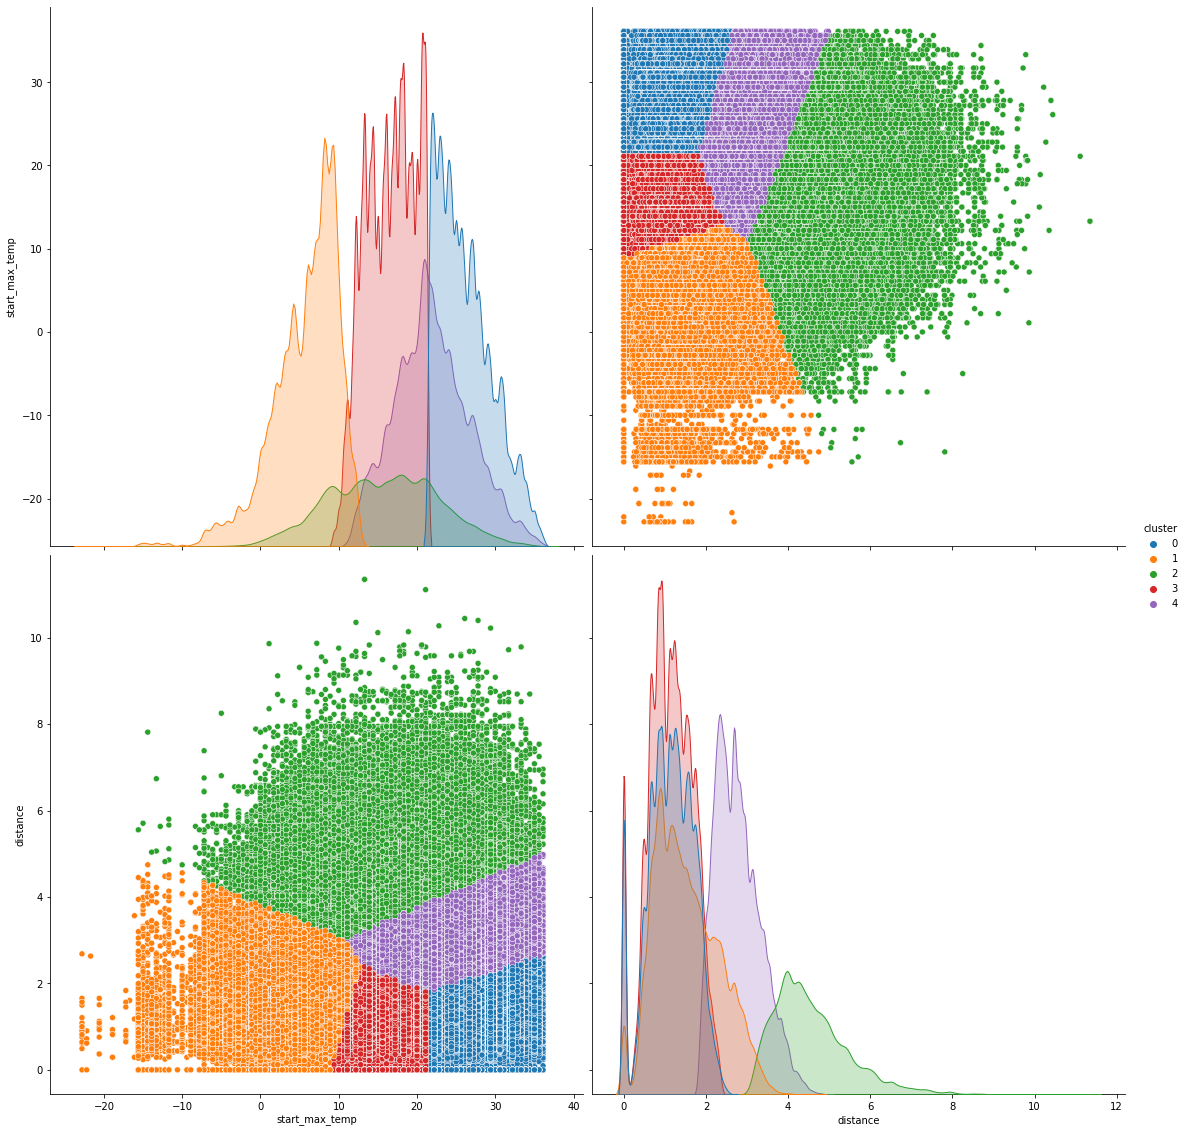

In [ ]:
sns.pairplot(data=weather_trip,height=8,hue='cluster',palette=sns.color_palette('tab10', 5))

[Text(0, 0.5, 'distance in km'),
 Text(0.5, 0, 'temperature in c°'),
 Text(0.5, 1.0, 'Trip types by distance & start temperature')]

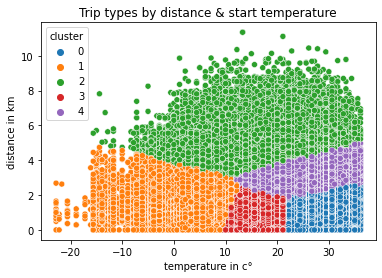

In [ ]:
sns.scatterplot(data=weather_trip, x='start_max_temp', y='distance', hue='cluster', palette=sns.color_palette('tab10', 5)).set(title='Trip types by distance & start temperature', xlabel='temperature in c°', ylabel='distance in km')

**Observations:** The Trips were divided in 5 clusters:
- zero: high temperatures and short distance of travel -> "warm weather customer"
- one: cold temperatures and medium distances -> "hardened customers"
- two: all temperatures, longer distances -> "regular long distance customer"
- three: warm temperatures and short distance of travel -> "fair weather customer"
- four: warm to high temperatures and medium distances -> "fair weather longer distance customers"

**Additional:** In Cluster 1 we can observe that the most customers ride even in extreme cold weather conditions. It is likely that these customers are heavy users of systems, no matter how hard the conditions are. 

## Clustering of Stations by Time and Popularity


In this part we try to cluster locations based on their demand patterns. Therefore we first cluster the data based on time and popularity. Afterwards, the results are related to the geographical location of the stations. 

In [ ]:
# Add start_hour_of_day to the data set
cluster_data['start_hour_of_day'] = pd.to_datetime(cluster_data['start_time']).dt.hour

The goal is to identify different patterns depending on the start and end stations. Therefore, the data is grouped based on the number of bookings per hour. The more bookings per hour, the more popular a station is.

In [ ]:
# Create Start and End Dataframes with new popularity "count" column.

booking_start_counts = cluster_data.groupby(['start_latitude','start_longitude', 'start_hour_of_day']).size().reset_index(name="count")
booking_end_counts = cluster_data.groupby(['end_latitude', 'end_longitude', 'start_hour_of_day']).size().reset_index(name="count")
booking_start_counts.head(2)

,start_latitude,start_longitude,start_hour_of_day,count
0,42.303469,-71.085347,0,1
1,42.303469,-71.085347,2,4


In [ ]:
# Simplified function, to map hour to cyclic time:
def hour_to_cyclic_time(hour):
    """
    Hours are assigned to integer values so that afternoon and noon have the same distance to night.
    This is important because K-Means is based on the Euclidean, which otherwise does not know
    that 23 and 1 o'clock are exactly as far away as e.g. 14 and 15 o'clock. 
    This function is simplified to obtain only one feature as opposed to e.g. a cosine sine transformation.  

    """
    if (hour >= 5) and (hour <= 13):
        return 1
    elif (hour >= 14) and (hour <= 21):
        return 3
    return 2



K-means is sensitive to outliers. Therefore scaling is necessary for the best results. Sklearn's StandardScaler is used here.

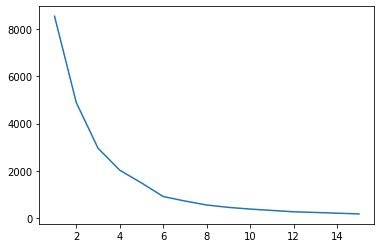

In [ ]:
# Scale values and plot elbow graph
scaler = StandardScaler()
booking_start_counts_scaled = booking_start_counts.copy()
booking_start_counts_scaled['start_hour_of_day'] = booking_start_counts_scaled['start_hour_of_day'].apply(hour_to_cyclic_time)
booking_start_counts_scaled[['count', 'start_hour_of_day']] = scaler.fit_transform(booking_start_counts_scaled[['count', 'start_hour_of_day']])
booking_end_counts_scaled = booking_end_counts.copy()
booking_end_counts_scaled['start_hour_of_day'] = booking_end_counts_scaled['start_hour_of_day'].apply(hour_to_cyclic_time)
booking_end_counts_scaled[['count', 'start_hour_of_day']] = scaler.fit_transform(booking_end_counts_scaled[['count', 'start_hour_of_day']])
plot_elbow_graph(booking_start_counts_scaled[['count', 'start_hour_of_day']])

In [ ]:
booking_start_counts_scaled

,start_latitude,start_longitude,start_hour_of_day,count
0,42.303469,-71.085347,0.045810,-0.695545
1,42.303469,-71.085347,0.045810,-0.688311
2,42.303469,-71.085347,0.045810,-0.685900
3,42.303469,-71.085347,0.045810,-0.688311
4,42.303469,-71.085347,-1.124685,-0.693134
...,...,...,...,...
4262,42.406302,-71.132446,1.216306,-0.603918
4263,42.406302,-71.132446,1.216306,-0.652142
4264,42.406302,-71.132446,0.045810,-0.652142
4265,42.406302,-71.132446,0.045810,-0.632853


 K-means++ is used because it is not sensitive to find local optima because it selects the cluster centroids for the defined number of clusters randomly. This decreases the probability of finding local optimas.

In [ ]:
# Fit k-means++ model with the booking start counts
n_clusters = 6
model = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
model.fit(booking_start_counts_scaled[['count', 'start_hour_of_day']])

KMeans(n_clusters=6, random_state=42)

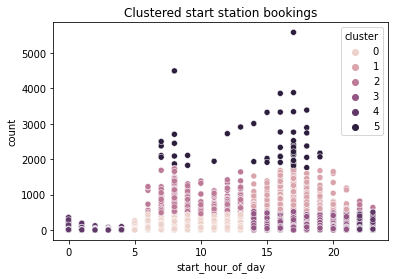

In [ ]:
#Plot clustered start station bookings
clustered_booking_start_counts = booking_start_counts.copy()
# Combine unscaled data with cluster results for interpretability
clustered_booking_start_counts['cluster'] = model.predict(booking_start_counts_scaled[['count', 'start_hour_of_day']])
sns.scatterplot(x='start_hour_of_day', y='count', data=clustered_booking_start_counts, hue='cluster').set_title('Clustered start station bookings')
plt.show()

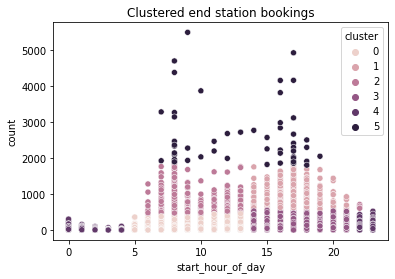

In [ ]:
# Plot end stations bookings with start station clusters for comparison 
clustered_booking_end_counts = booking_end_counts.copy()
clustered_booking_end_counts['cluster'] = model.predict(booking_end_counts_scaled[['count', 'start_hour_of_day']])
sns.scatterplot(x='start_hour_of_day', y='count', data=clustered_booking_end_counts, hue='cluster').set_title('Clustered end station bookings')
plt.show()

The cluster 3 is both, in the right and the left of the plot, because the distance has been mapped with the `map_hour_to_cyclic_time` function.

Note that the end stations are clustered with the start station model to have a good comparison between the two results.


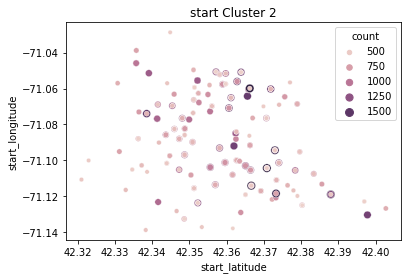

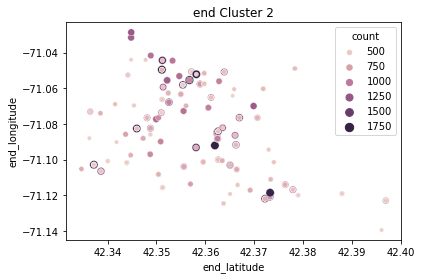

In [ ]:
# Morning to Noon, equals cluster 2 (from 6:00 to 13:00)

cluster = 2

sns.scatterplot(x='start_latitude', y='start_longitude', data=clustered_booking_start_counts[clustered_booking_start_counts['cluster'] == cluster], hue='count', size='count').set(title='start Cluster 2')
plt.show()
sns.scatterplot(x='end_latitude', y='end_longitude', data=clustered_booking_end_counts[clustered_booking_end_counts['cluster'] == cluster], hue='count', size='count').set(title='end Cluster 2')
plt.show()

**Zooming in:**
By looking at Cluster number 2, we can observe how demand patterns change between 6:00 to 13:00


In the morning people drive from the outscirds towards the center 



#References


[1] S. Kumar, "Understanding K-Means, K-Means++ and, K-Medoids Clustering Algorithms", June 11, 2020. [Online]. Available: towards Data Science, https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca. [Accessed January 24, 2022].

[2] A. Shaw, "Bike Sharing Demand-Exploratory Data Analysis", October 25, 2019. [Online]. Available: medium, https://medium.com/@shawanugya12/bike-sharing-demand-exploratory-data-analysis-2095a1ed4bd8#6fb5. [Accessed January 24, 2022].


